# EbayesThresh Toy ex

SEOYEON CHOI  
2023-05-18

# Import

In [47]:
from itstgcn.learners import * 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [49]:
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as rpyn
ebayesthresh = importr('EbayesThresh').ebayesthresh

-   While ${\bf p}_y$ serves as a consistent estimator for
    $\mathbb{E}[|{\bf V}^H{\bf y}|^2]$, it is not an efficient
    estimator, and therefore, improvement is needed (Djuric and Richard
    2018). The traditional approach for improvement is to use the
    windowed periodogram.

-   The windowed periodogram is efficient in detecting specific
    frequencies or periods, but it may not be as efficient in estimating
    the underlying function. One notable paper that utilized the
    windowed periodogram is the one that detected the El Niño
    phenomenon.

-   As this structure exhibits a “sparse signal + heavy-tailed”
    characteristics, by applying Bayesian modeling and thresholding
    ${\bf p}_y$, we can estimate an appropriate ${\bf p}_{pp}$ as
    discussed in (Johnstone and Silverman 2004).

# Bayesian Model

$x_i \sim N(\mu_i,1)$

[확률변수](https://guebin.github.io/AP2023/posts/II.%20%ED%99%95%EB%A5%A0%EB%A1%A0%EA%B8%B0%EC%B4%88/2023-05-02-09wk.html)가
잘 정의되어 있을때, 여기서 $\mu_i$를 정하는 Baysian.

-   $\mu_i \sim$ 사전분포($\mu_i$를 뽑을 수 있는)
-   $(\mu_i | X_i = x_i)^n_{i=1} \sim$ 사후분포

ex) $N(10,1) \sim$ 사전분포

관측치

In [454]:
_obs = [7.1,6.9,8.5]

In [457]:
np.mean(_obs)

관측치를 보니 평균이 10이 아닌 것 같다.

$N(10-3,1) \sim$ 사후분포

-   여기서, $10-3$이 posterior meman
-   사후 분포를 정의할때, 이벤트의 mean이냐, median이냐로 잡는 방법은
    정해진 것이 아니다.(이베이즈에서는 median으로 잡음)

Ebayes는 사전분포를 Heavy-tail으로 정의했다.

**heavy tail?**

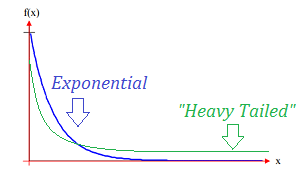

$\mu_x \sim$ Double Exponential $= p_{pp} + p_{ac}$ -\> 혼합형(misture)
= pure point + absolutely continuous

$E(\mu_i | X_i = x_i) = \hat{\mu}_i$ -\> thresholding의 결과

$f_{prior}(\mu) = (1-w)\delta_0(\mu) + w \gamma (\mu)$

-   $\delta_0$ = [디렉함수(특정값이 아니면 다 0으로
    봄)](https://guebin.github.io/AP2023/posts/II.%20%ED%99%95%EB%A5%A0%EB%A1%A0%EA%B8%B0%EC%B4%88/2023-06-06-14wk.html#%EC%9D%B4%EC%82%B0%ED%99%95%EB%A5%A0%EB%B3%80%EC%88%98)
-   $\gamma = \frac{a}{2} e^{-a|\mu|}$

**Ebayes의 역할 = 자동으로 $w$를 계산 혹은 추정**

-   $1-w$ 확률로 $\delta_0$를 정의, $w$의 확룔로 $\gamma$를 정의.

$X_i = \mu_i + \epsilon_i, \epsilon_i \sim N(0,1)$에서 $\mu_i$를 찾는게
목적이다. 이게 바로 $\eta$값

1.  Ebayes로 sparse signal만 골러낼 것이다.
2.  평균 이상의 값에서 자를 것이다.
    -   thresh(임계치)를 잡는 게 어려울 텐데, 위에서 이베이즈가 $w$를
        자동으로 잡아 확률 계산되는 방법론을 제안한 것,
3.  baysian modeling 사용하여 heavy tail + impulse(sparse)에서 posterior
    median 추정하여 임계값thresh으로 $p$에서 $p_{pp}$를 추출하는 것이
    GODE 목적

# EbayesThresh

In [50]:
T = 100

In [51]:
t = np.arange(T)/T * 10

In [52]:
y_true = 3*np.sin(0.5*t) + 1.2*np.sin(1.0*t) + 0.5*np.sin(1.2*t) 

In [53]:
y = y_true + np.random.normal(size=T)

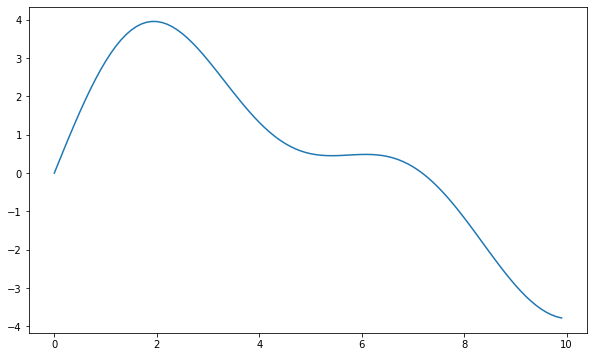

In [54]:
plt.figure(figsize=(10,6))
plt.plot(t,y_true)

`-` 관찰한 신호

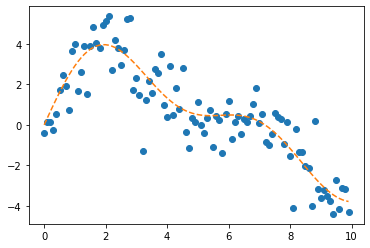

In [55]:
plt.plot(t,y,'o')
plt.plot(t,y_true,'--')

`-` 퓨리에 변환

In [56]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

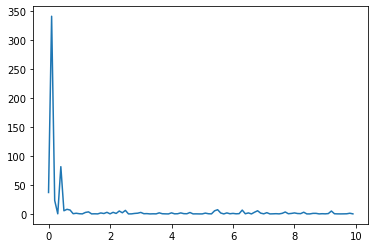

In [57]:
plt.plot(t,fbar**2) # periodogram 

`-` threshed

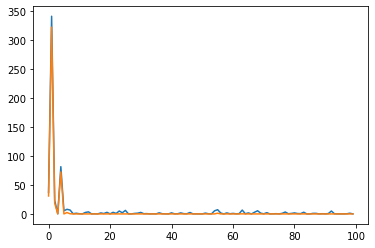

In [58]:
fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

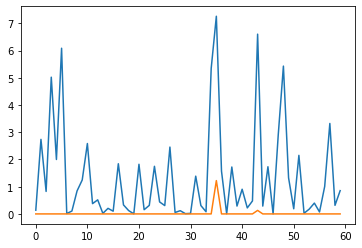

In [59]:
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

`-` 역퓨리에변환

In [60]:
yhat = Psi @ fbar_threshed # inverse dft

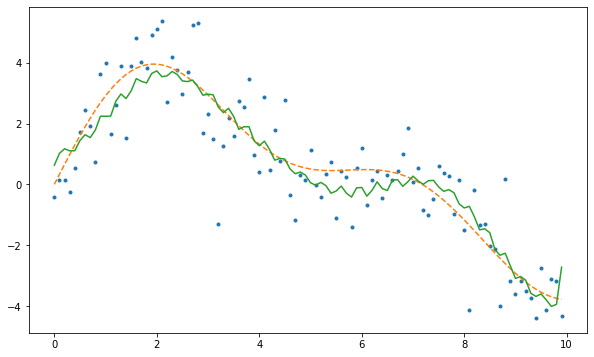

In [61]:
plt.figure(figsize=(10,6))
plt.plot(t,y,'.')
plt.plot(t,y_true,'--')
plt.plot(t,yhat)

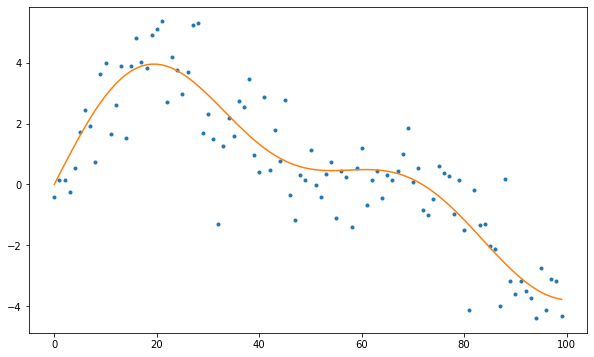

In [62]:
plt.figure(figsize=(10,6))
plt.plot(y,'.')
plt.plot(y_true)

# Result

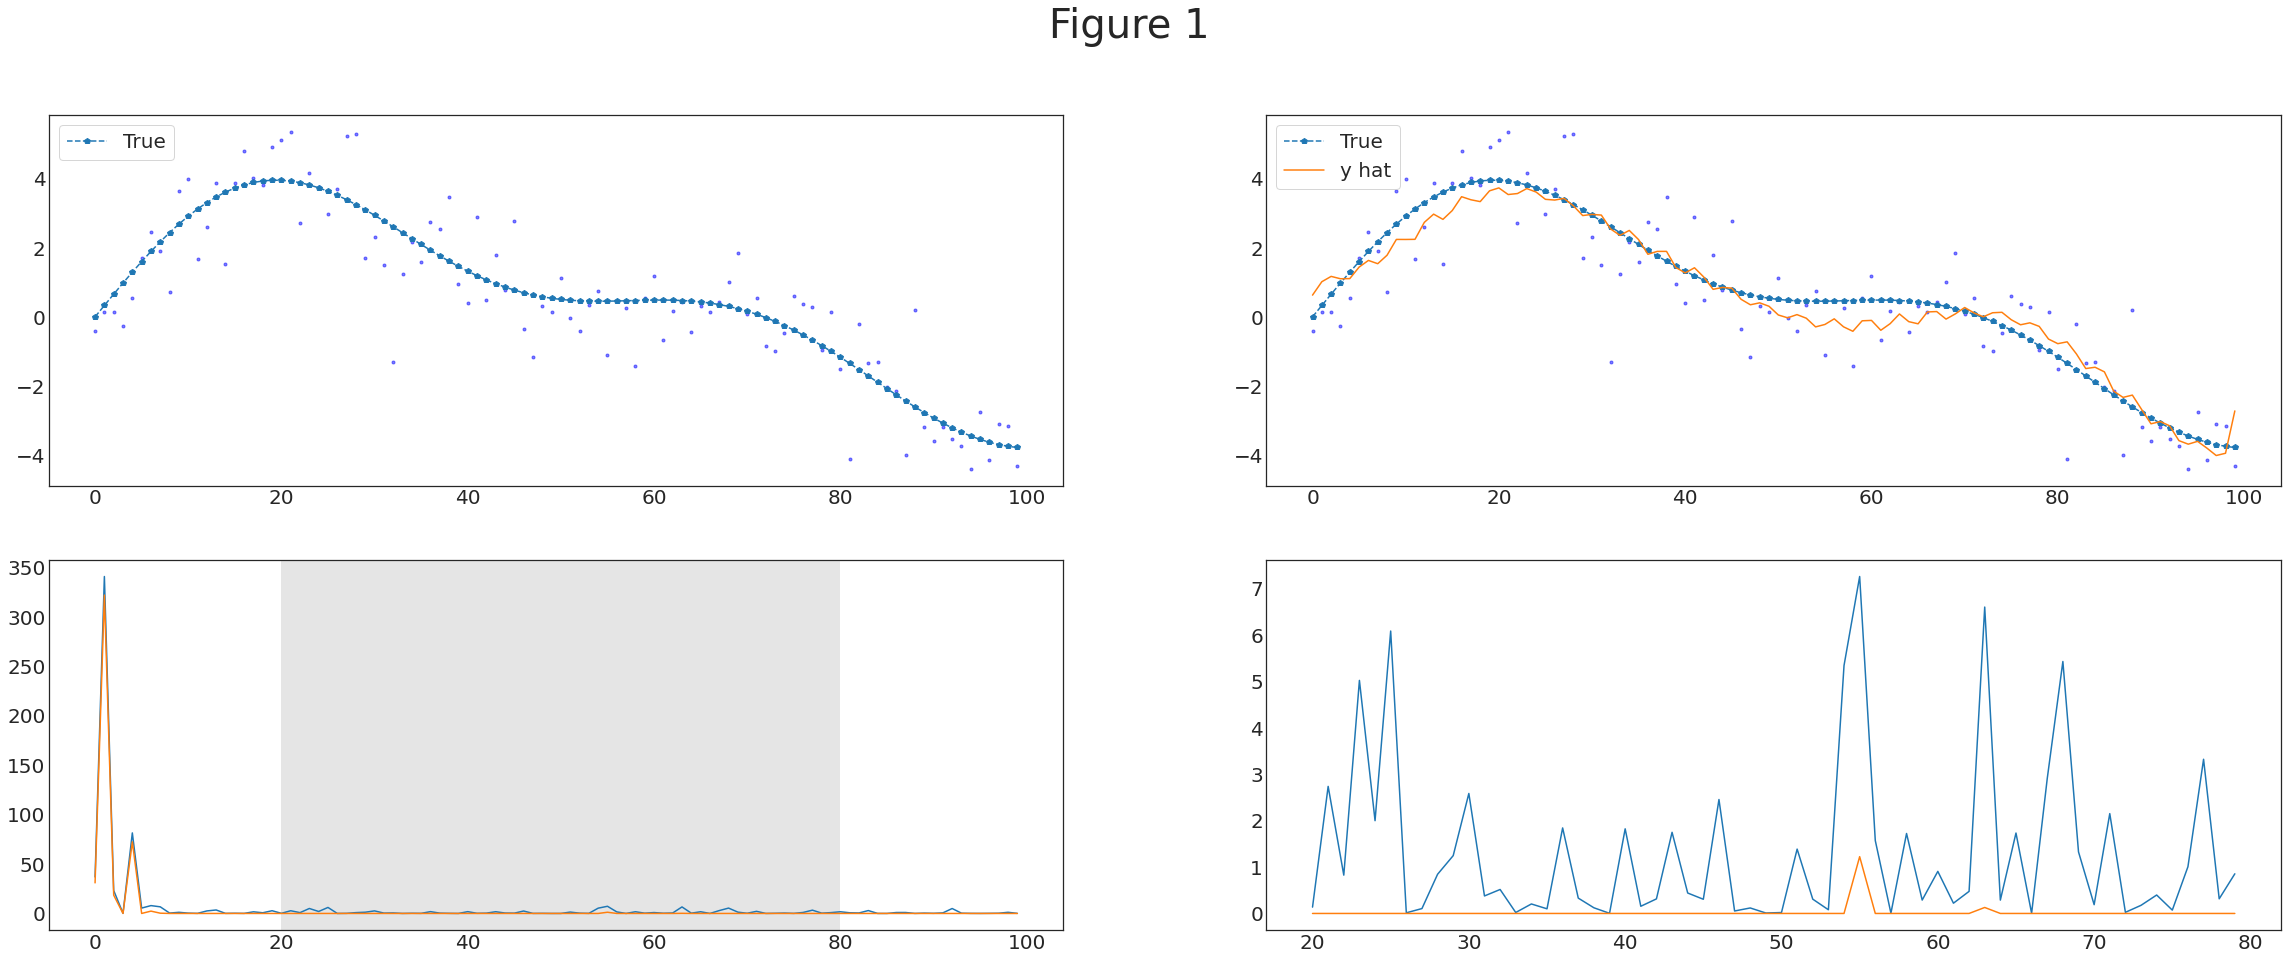

In [63]:
with plt.style.context('seaborn-white'):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(40,15))
    fig.suptitle('Figure 1',fontsize=40)
    
    ax1.plot(y, 'b.',alpha=0.5)
    ax1.plot(y_true,'p--',label='True')
    ax1.legend(fontsize=20,loc='upper left',facecolor='white', frameon=True)
    
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    ax2.plot(y, 'b.',alpha=0.5)
    ax2.plot(y_true,'p--',label='True')
    ax2.plot(yhat,label='y hat')
    ax2.legend(fontsize=20,loc='upper left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot((fbar**2)) # periodogram 
    ax3.plot((fbar_threshed**2)) 
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.axvspan(20, 80, facecolor='gray', alpha=0.2)

    
    ax4.plot(range(20, 80),(fbar**2)[20:80]) # periodogram 
    ax4.plot(range(20, 80),(fbar_threshed**2)[20:80]) 
    ax4.set_xticks(range(20, 81, 10))
    ax4.set_xticklabels(range(20, 81, 10))
    # ax4.set_xticklabels(['20','40','60'])
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)

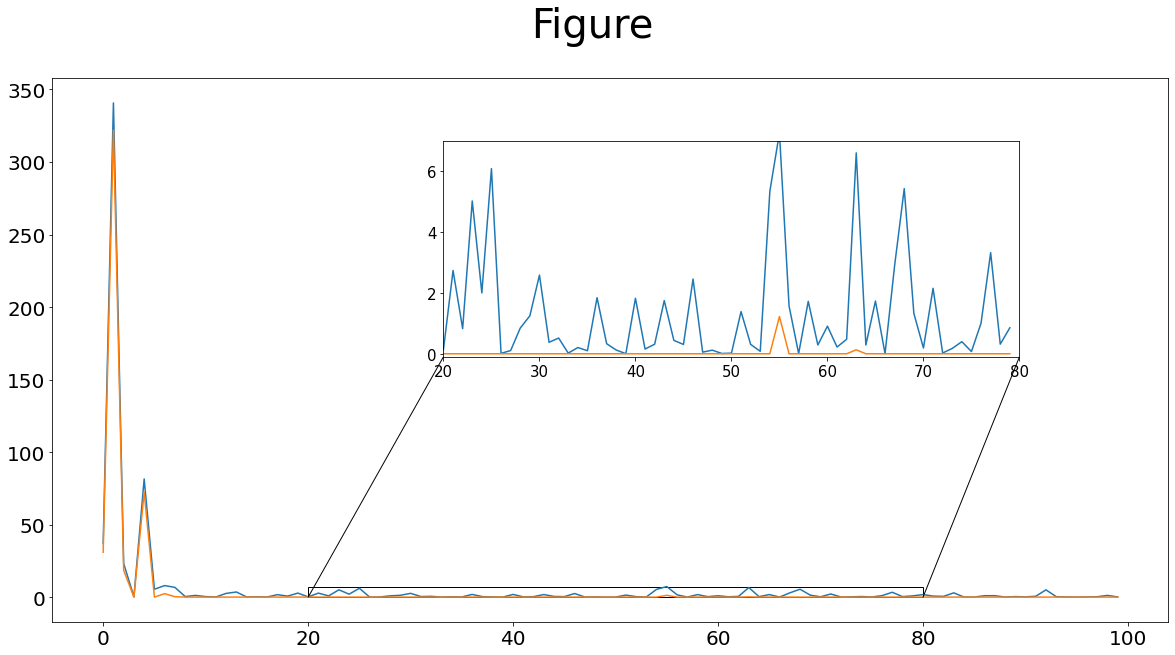

In [64]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
plt.figure(figsize = (20,10))
plt.suptitle('Figure',fontsize=40)
ax = plt.subplot(1, 1, 1)
ax.plot(range(0,100),(fbar**2))
ax.plot((fbar_threshed**2)) 
axins = inset_axes(ax, 8, 3, loc = 1, bbox_to_anchor=(0.8, 0.8),
                   bbox_transform = ax.figure.transFigure)
axins.plot(range(20, 80),(fbar**2)[20:80])
axins.plot(range(20, 80),(fbar_threshed**2)[20:80]) 
axins.set_xlim(20, 80)
axins.set_ylim(-0.1, 7)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec = "0.01")
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
axins.tick_params(axis='y', labelsize=15)
axins.tick_params(axis='x', labelsize=15)
# plt.savefig('Ebayes_Toy.png')

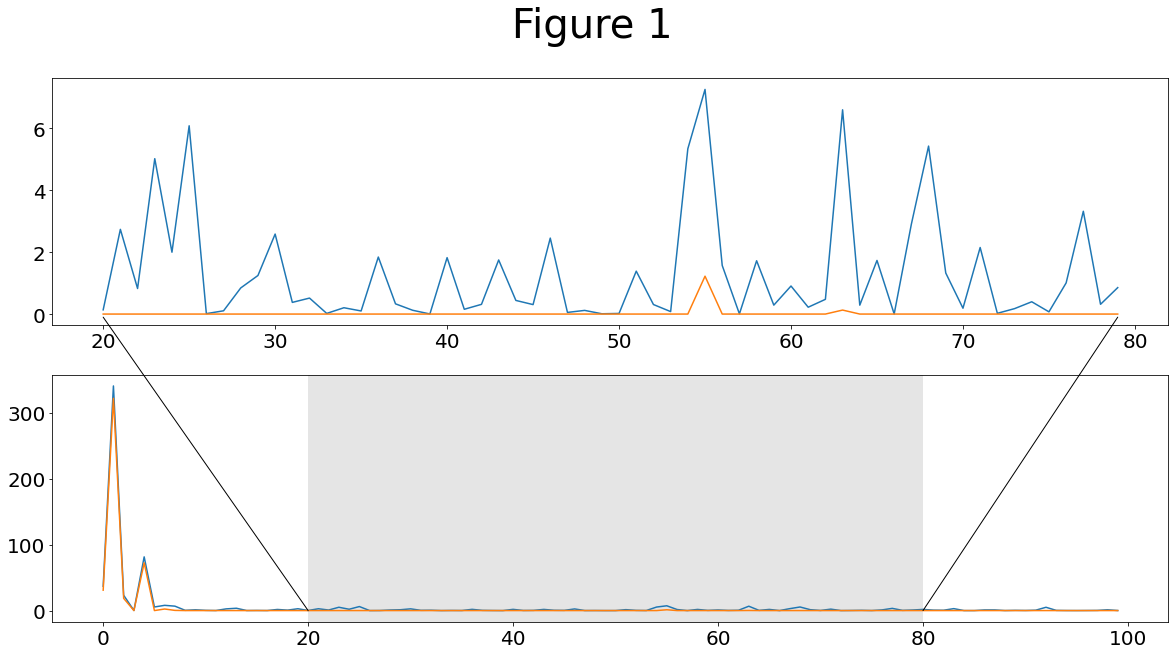

In [65]:
from matplotlib.patches import ConnectionPatch
fig = plt.figure(figsize=(20,10))
plt.suptitle('Figure 1',fontsize=40)
plot1 = fig.add_subplot(2,2,(1,2))

plot1.plot(range(20, 80),(fbar**2)[20:80]) # periodogram 
plot1.plot(range(20, 80),(fbar_threshed**2)[20:80]) 
plot1.set_xticks(range(20, 81, 10))
plot1.set_xticklabels(range(20, 81, 10))
plot1.tick_params(axis='y', labelsize=20)
plot1.tick_params(axis='x', labelsize=20)

plot3 = fig.add_subplot(2,2,(3,4)) 

plot3.plot((fbar**2)) # periodogram 
plot3.plot((fbar_threshed**2)) 
plot3.tick_params(axis='y', labelsize=20)
plot3.tick_params(axis='x', labelsize=20)
plot3.axvspan(20, 80, facecolor='gray', alpha=0.2)

# plot3.fill_between((20, 80), 10, 60, facecolor= "red", alpha = 0.2)
conn1 = ConnectionPatch(xyA = (20, -0.1), coordsA=plot1.transData,
                       xyB=(20, 0), coordsB=plot3.transData, color = 'black')
fig.add_artist(conn1)
conn2 = ConnectionPatch(xyA = (79, -0.1), coordsA=plot1.transData,
                       xyB=(80, 0), coordsB=plot3.transData, color = 'black')
fig.add_artist(conn2)
plt.show()

# In article

In [10]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer


In [8]:
import rpy2

In [3]:
from rpy2.robjects.packages import importr

In [5]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [ ]:
#import rpy2
#import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as rpyn
GNAR = importr('GNAR') # import GNAR 
#igraph = importr('igraph') # import igraph 
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [13]:
%%R
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))

$X_i$에서 $\mu_i$ 추출 가능하는 것을 증명할 예제

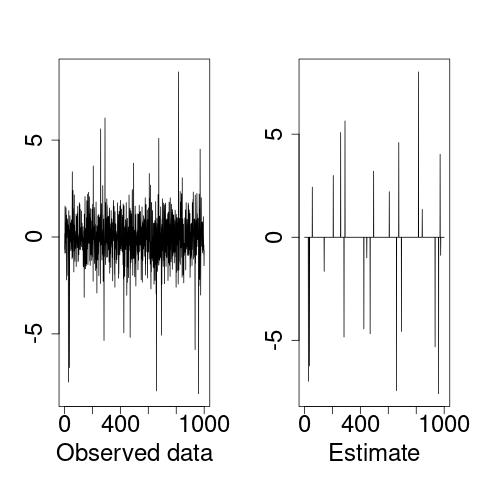

In [43]:
%%R
# png("Ebayes_plot1.png", width=1600, height=800)
par(mfrow=c(1,2))
par(cex.axis=2) 
par(cex.lab=2)
plot(x, type='l', xlab="Observed data", ylab="")
plot(ebayesthresh(x, sdev=1),type='l', xlab="Estimate", ylab="")
# dev.off()

In [89]:
import itstgcn

In [70]:
itstgcn.make_Psi(T)

``` python
def trim(f):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape
    Psi = make_Psi(T)
    fbar = Psi.T @ f # apply dft 
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
    fhat = Psi @ fbar_threshed # inverse dft 
    return fhat
```

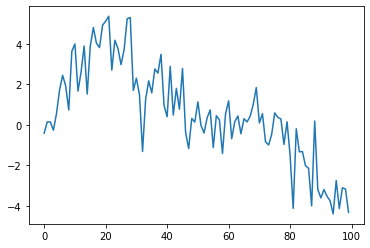

In [84]:
plt.plot(y)

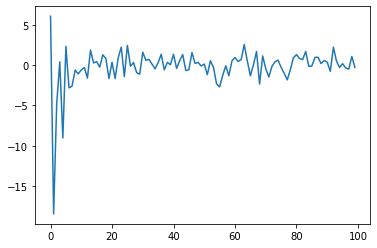

In [80]:
plt.plot(itstgcn.make_Psi(T).T@y)

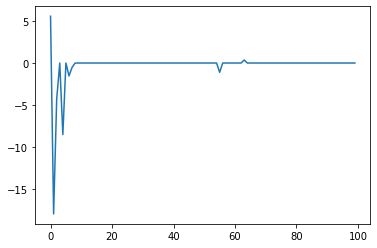

In [178]:
plt.plot(ebayesthresh(FloatVector(itstgcn.make_Psi(T).T@y)))

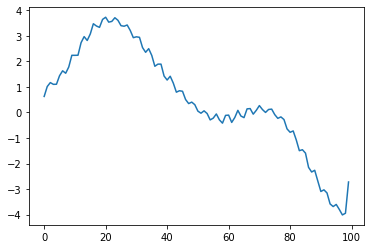

In [179]:
plt.plot(itstgcn.make_Psi(T)@ebayesthresh(FloatVector(itstgcn.make_Psi(T).T@y)))

In [358]:
_T = 1000

In [359]:
_t = np.arange(_T)/_T * 10

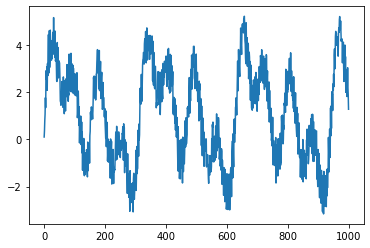

In [379]:
_x = 1.5*np.sin(2*_t)+2*np.random.rand(_T)+1.5*np.sin(4*_t)+1.5*np.sin(8*_t)
plt.plot(_x)

In [406]:
import itstgcn

In [423]:
class Eval_csy:
    def __init__(self,learner,train_dataset):
        self.learner = learner
        # self.learner.model.eval()
        try:self.learner.model.eval()
        except:pass
        self.train_dataset = train_dataset
        self.lags = self.learner.lags
        rslt_tr = self.learner(self.train_dataset) 
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()

In [415]:
_node_ids = {'node1':0,'node2':1}

_FX1 = np.stack([_x,_x],axis=1).tolist()

_edges1 = torch.tensor([[0,1]]).tolist()

data_dict1 = {'edges':_edges1, 'node_ids':_node_ids, 'FX':_FX1}

data1 = pd.DataFrame({'x':_x,'x1':_x,'xer':_x,'xer1':_x})

In [416]:
loader1 = itstgcn.DatasetLoader(data_dict1)

In [432]:
dataset = loader1.get_dataset(lags=2)

In [433]:
mindex = itstgcn.rand_mindex(dataset,mrate=0.7)
dataset_miss = itstgcn.miss(dataset,mindex,mtype='rand')

In [434]:
dataset_padded = itstgcn.padding(dataset_miss,interpolation_method='linear')

In [435]:
lrnr = itstgcn.StgcnLearner(dataset_padded)

In [445]:
lrnr.learn(filters=16,epoch=10)

10/10

In [446]:
evtor = Eval_csy(lrnr,dataset_padded)

In [447]:
lrnr_2 = itstgcn.ITStgcnLearner(dataset_padded)

In [448]:
lrnr_2.learn(filters=16,epoch=10)

10/10

In [449]:
evtor_2 = Eval_csy(lrnr_2,dataset_padded)

Psi

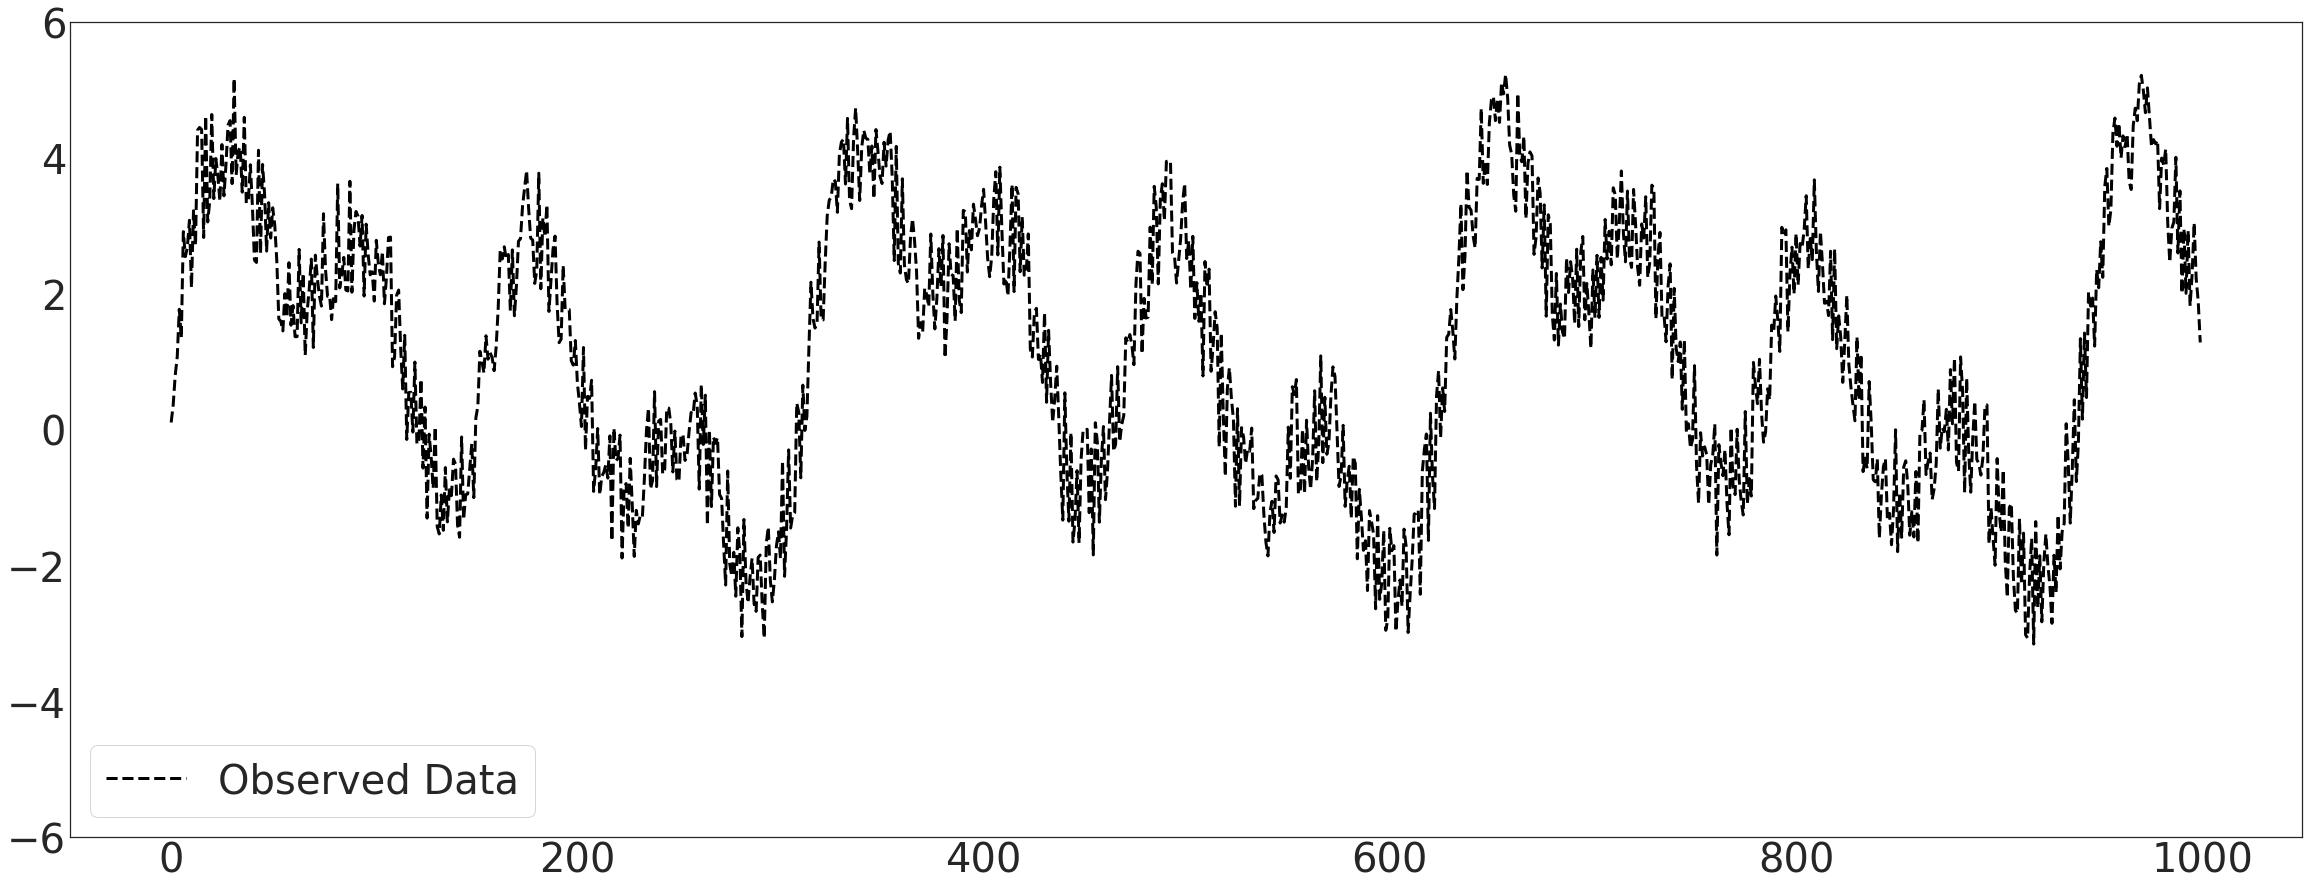

In [398]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    ax1.plot(_x,'k--',label='Observed Data',lw=3)
    ax1.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
    ax1.set_ylim(-6,6)
plt.savefig('Ebayes_fst.pdf', format='pdf')

fourier transform

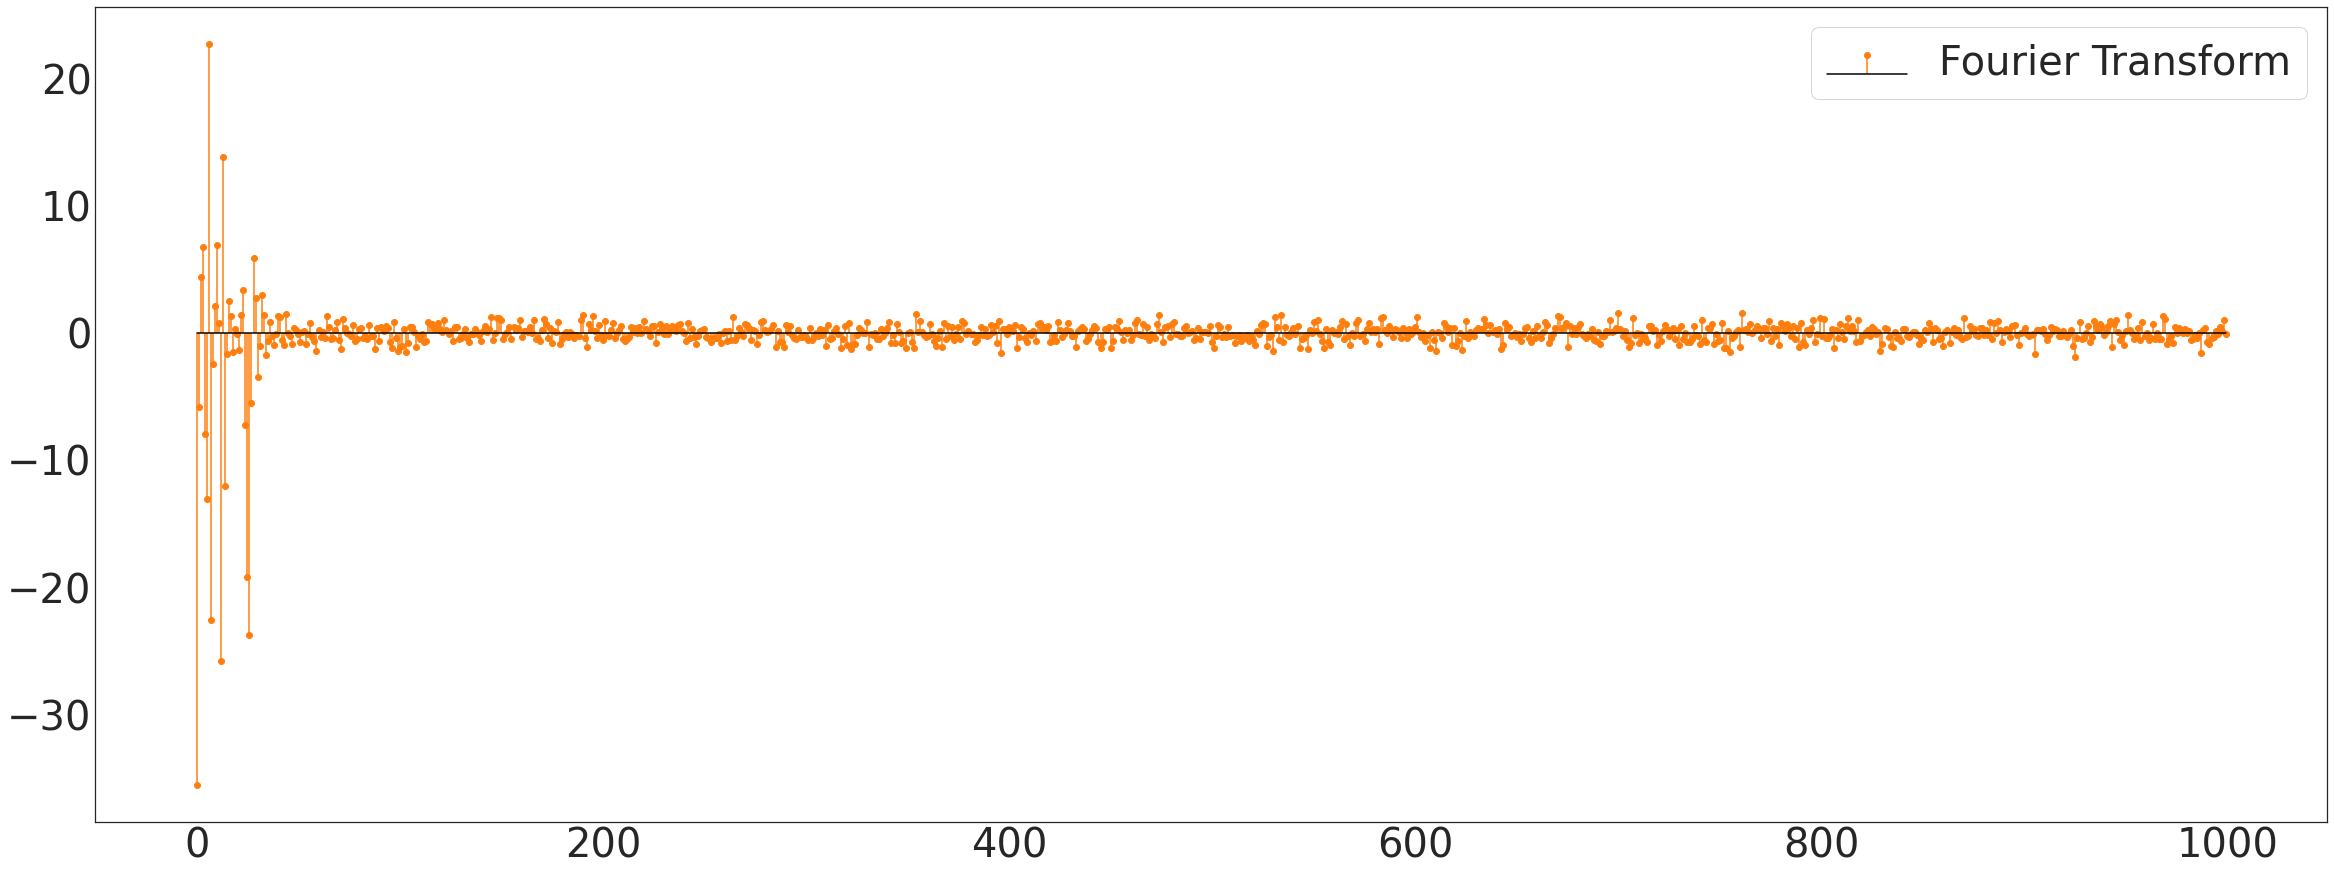

In [399]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    # ax1.plot(itstgcn.make_Psi(_T).T@np.array(_x),'-',color='C1',label='Fourier Transform',lw=3)
    ax1.stem(itstgcn.make_Psi(_T).T@np.array(_x),linefmt='C1-',basefmt='k-',label='Fourier Transform')
    ax1.legend(fontsize=40,loc='upper right',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
plt.savefig('Ebayes_snd.pdf', format='pdf')

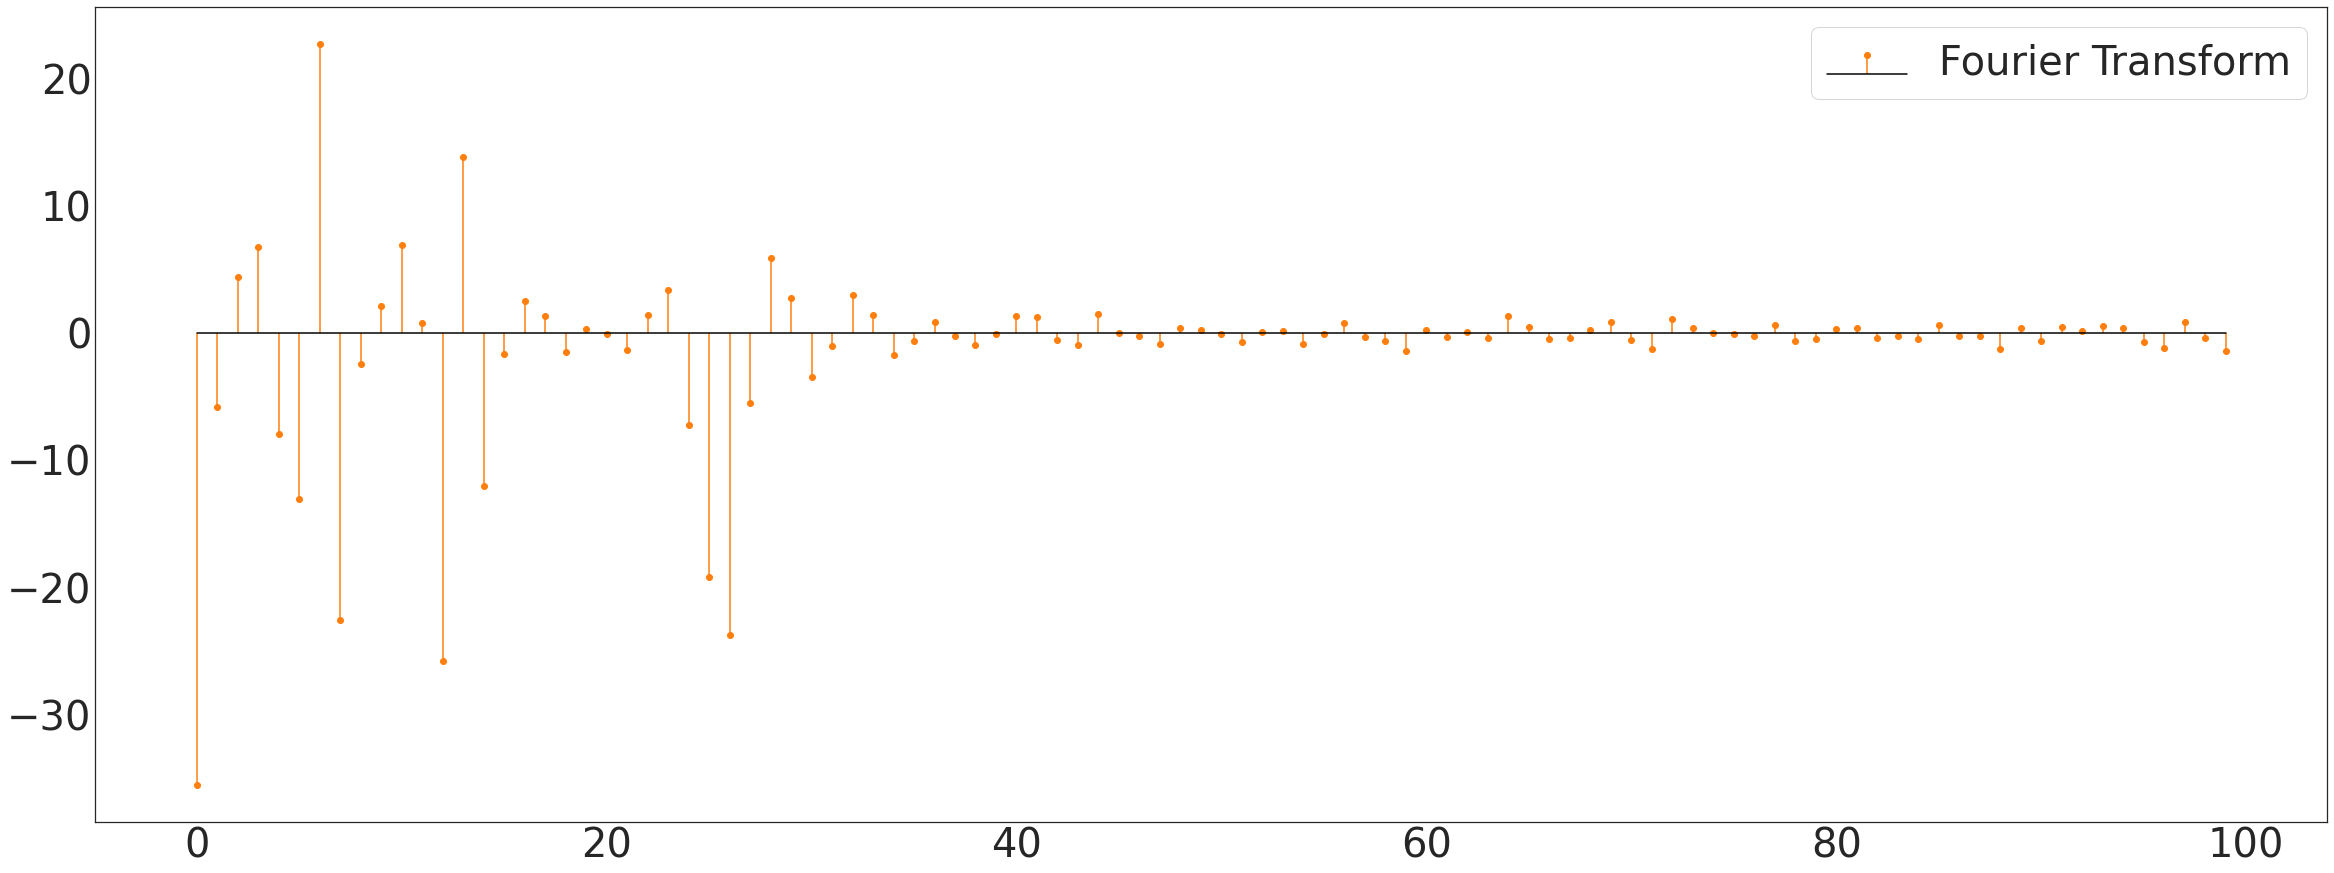

In [400]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    # ax1.plot(itstgcn.make_Psi(_T).T@np.array(_x),'-',color='C1',label='Fourier Transform',lw=3)
    ax1.stem((itstgcn.make_Psi(_T).T@np.array(_x))[:100],linefmt='C1-',basefmt='k-',label='Fourier Transform')
    ax1.legend(fontsize=40,loc='upper right',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
plt.savefig('Ebayes_snd_zin.pdf', format='pdf')

Ebayesthresh/trim

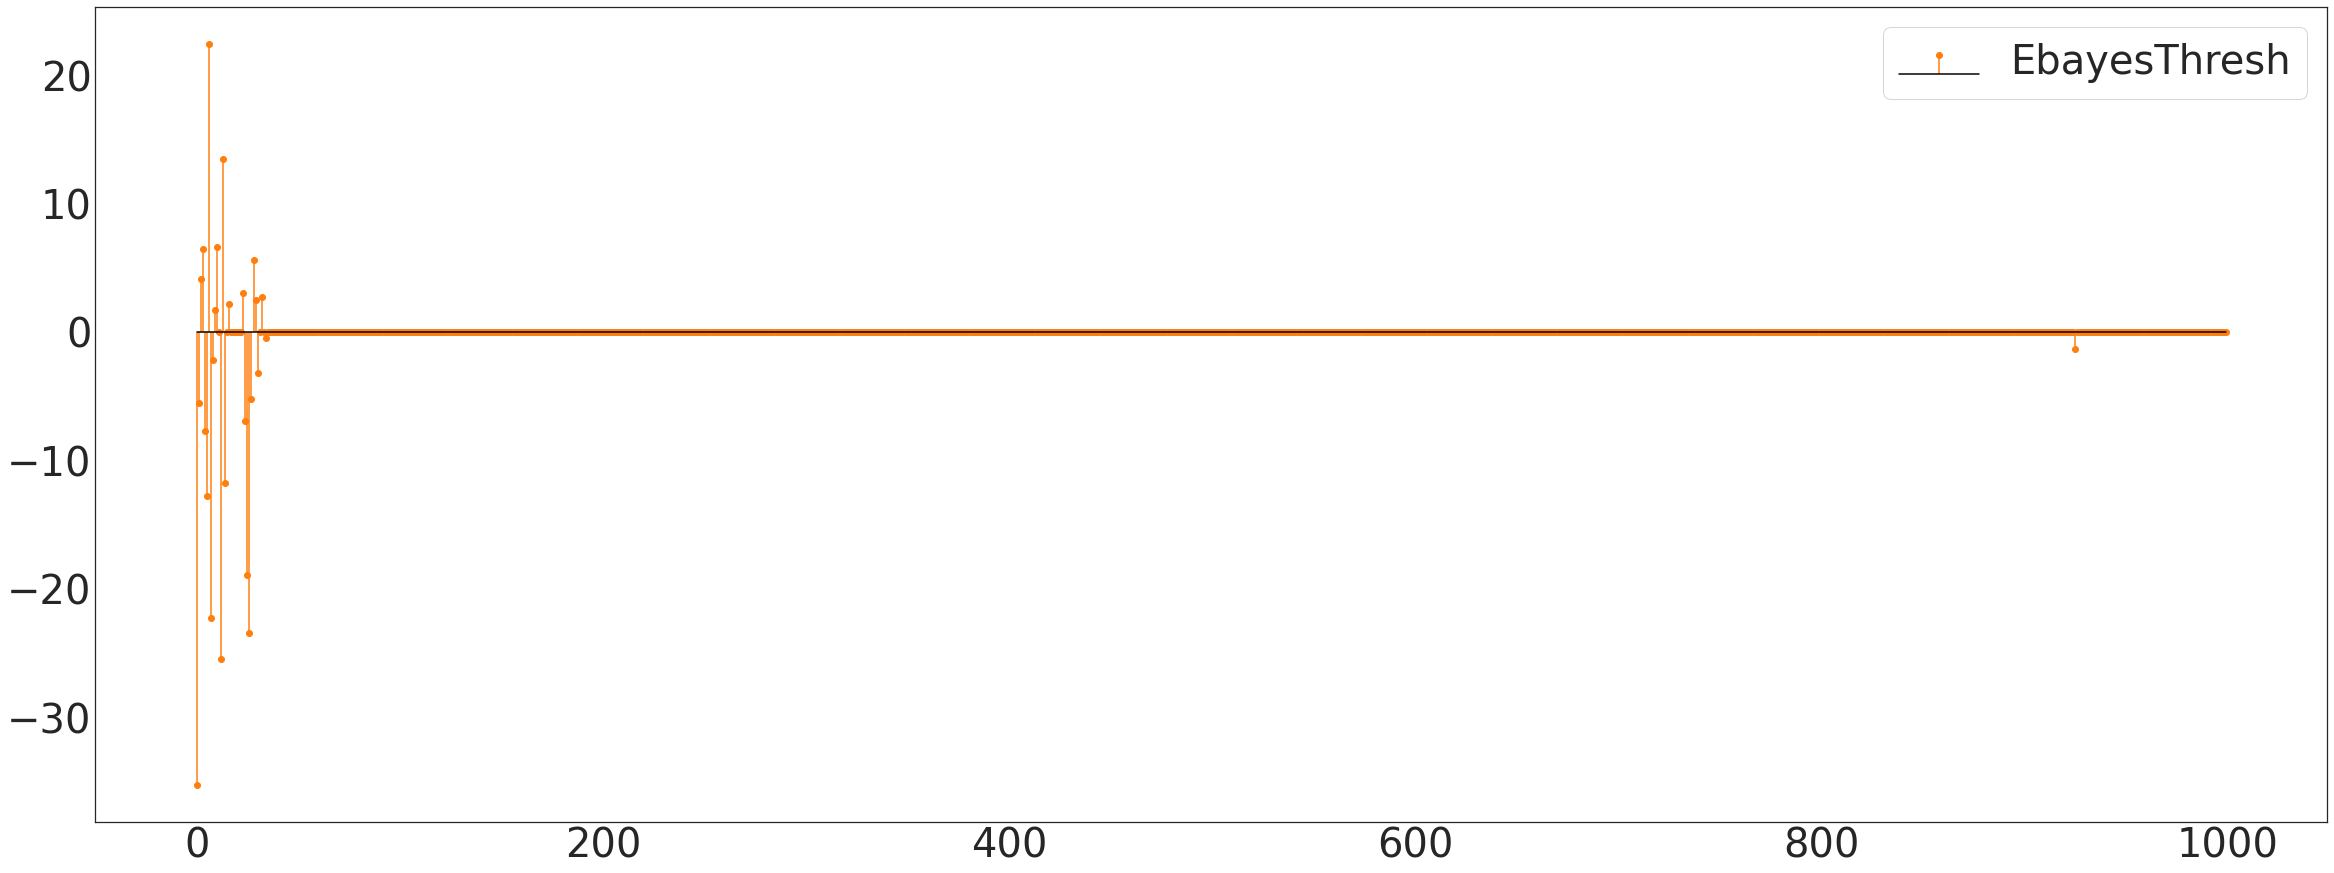

In [404]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    # ax1.plot(ebayesthresh(FloatVector(itstgcn.make_Psi(_T).T@np.array(_x))),'-',color='C1',label='EbayesThresh',lw=3)
    ax1.stem(ebayesthresh(FloatVector(itstgcn.make_Psi(_T).T@np.array(_x))),linefmt='C1-',basefmt='k-',label='EbayesThresh')
    ax1.legend(fontsize=40,loc='upper right',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
plt.savefig('Ebayes_trd.pdf', format='pdf')

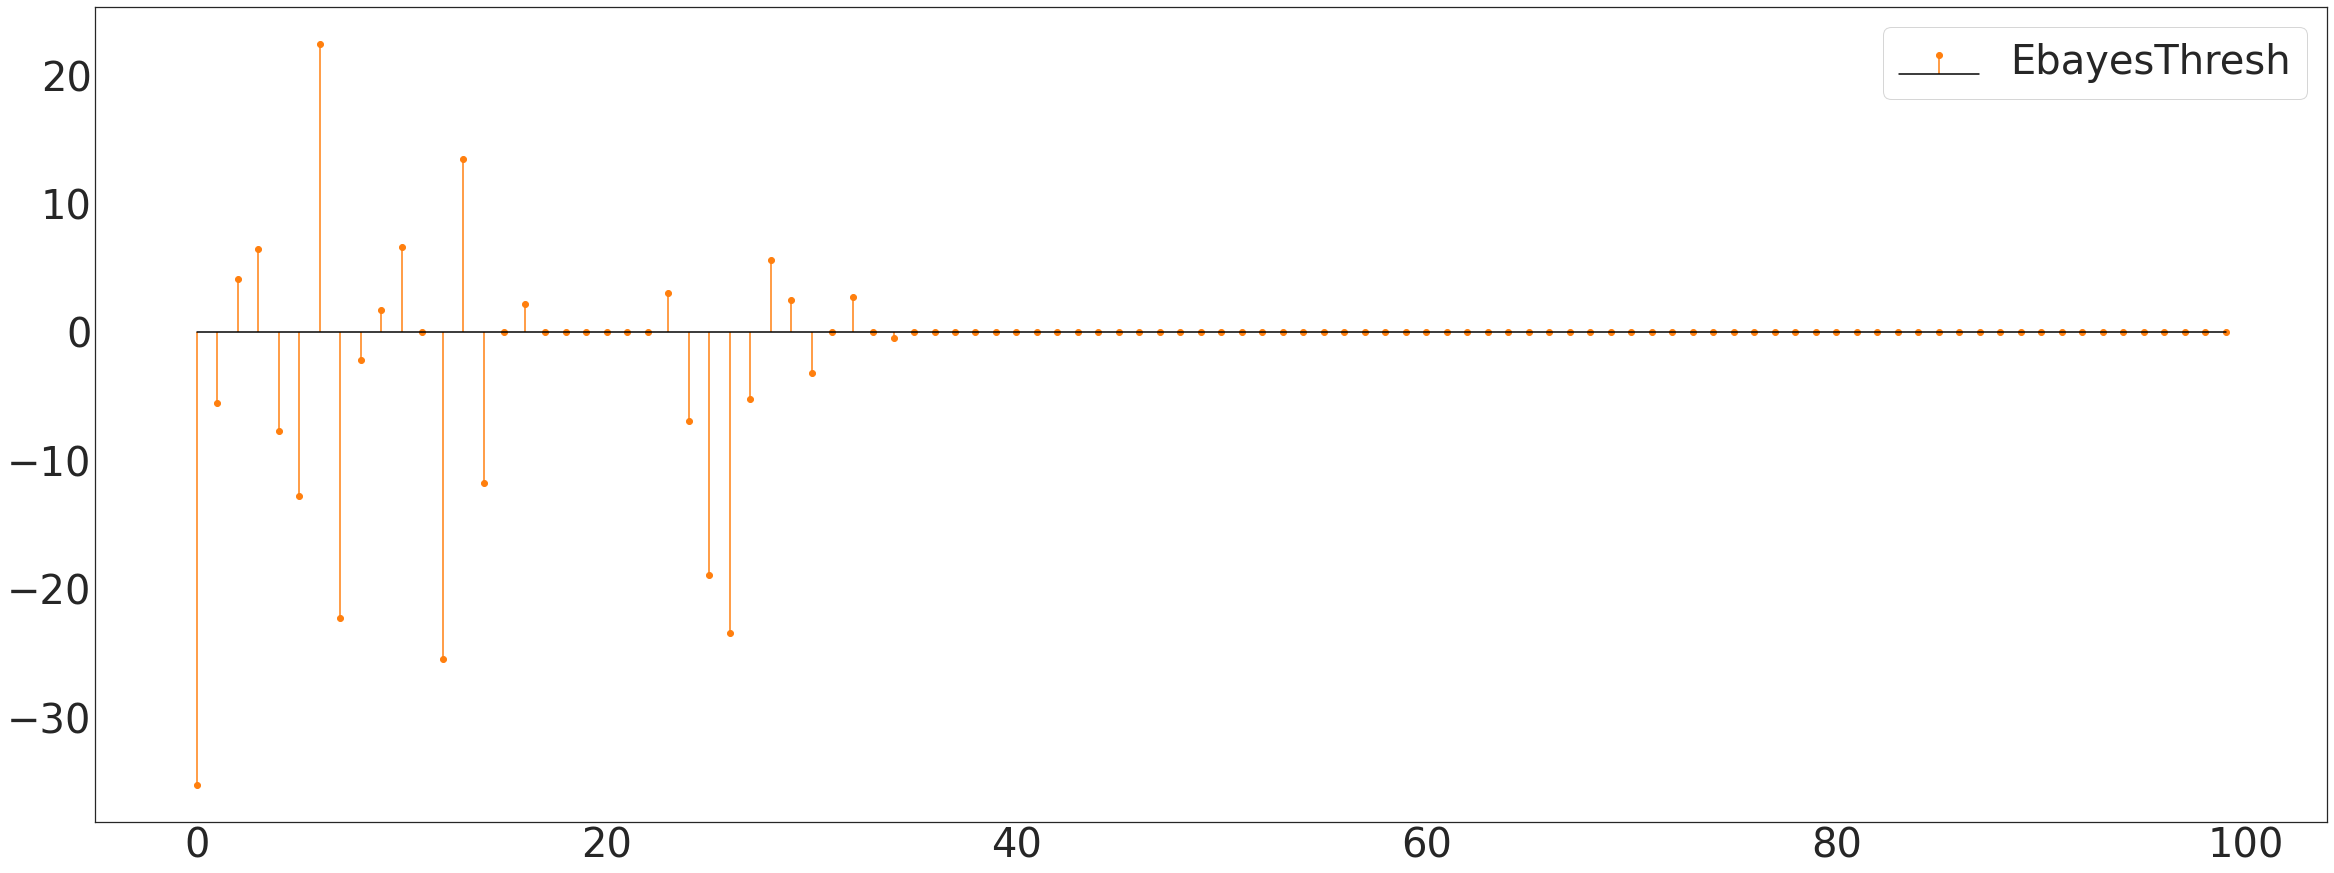

In [402]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    # ax1.plot(ebayesthresh(FloatVector(itstgcn.make_Psi(_T).T@np.array(_x))),'-',color='C1',label='EbayesThresh',lw=3)
    ax1.stem((ebayesthresh(FloatVector(itstgcn.make_Psi(_T).T@np.array(_x))))[:100],linefmt='C1-',basefmt='k-',label='EbayesThresh')
    ax1.legend(fontsize=40,loc='upper right',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
plt.savefig('Ebayes_trd_zout.pdf', format='pdf')

fhat

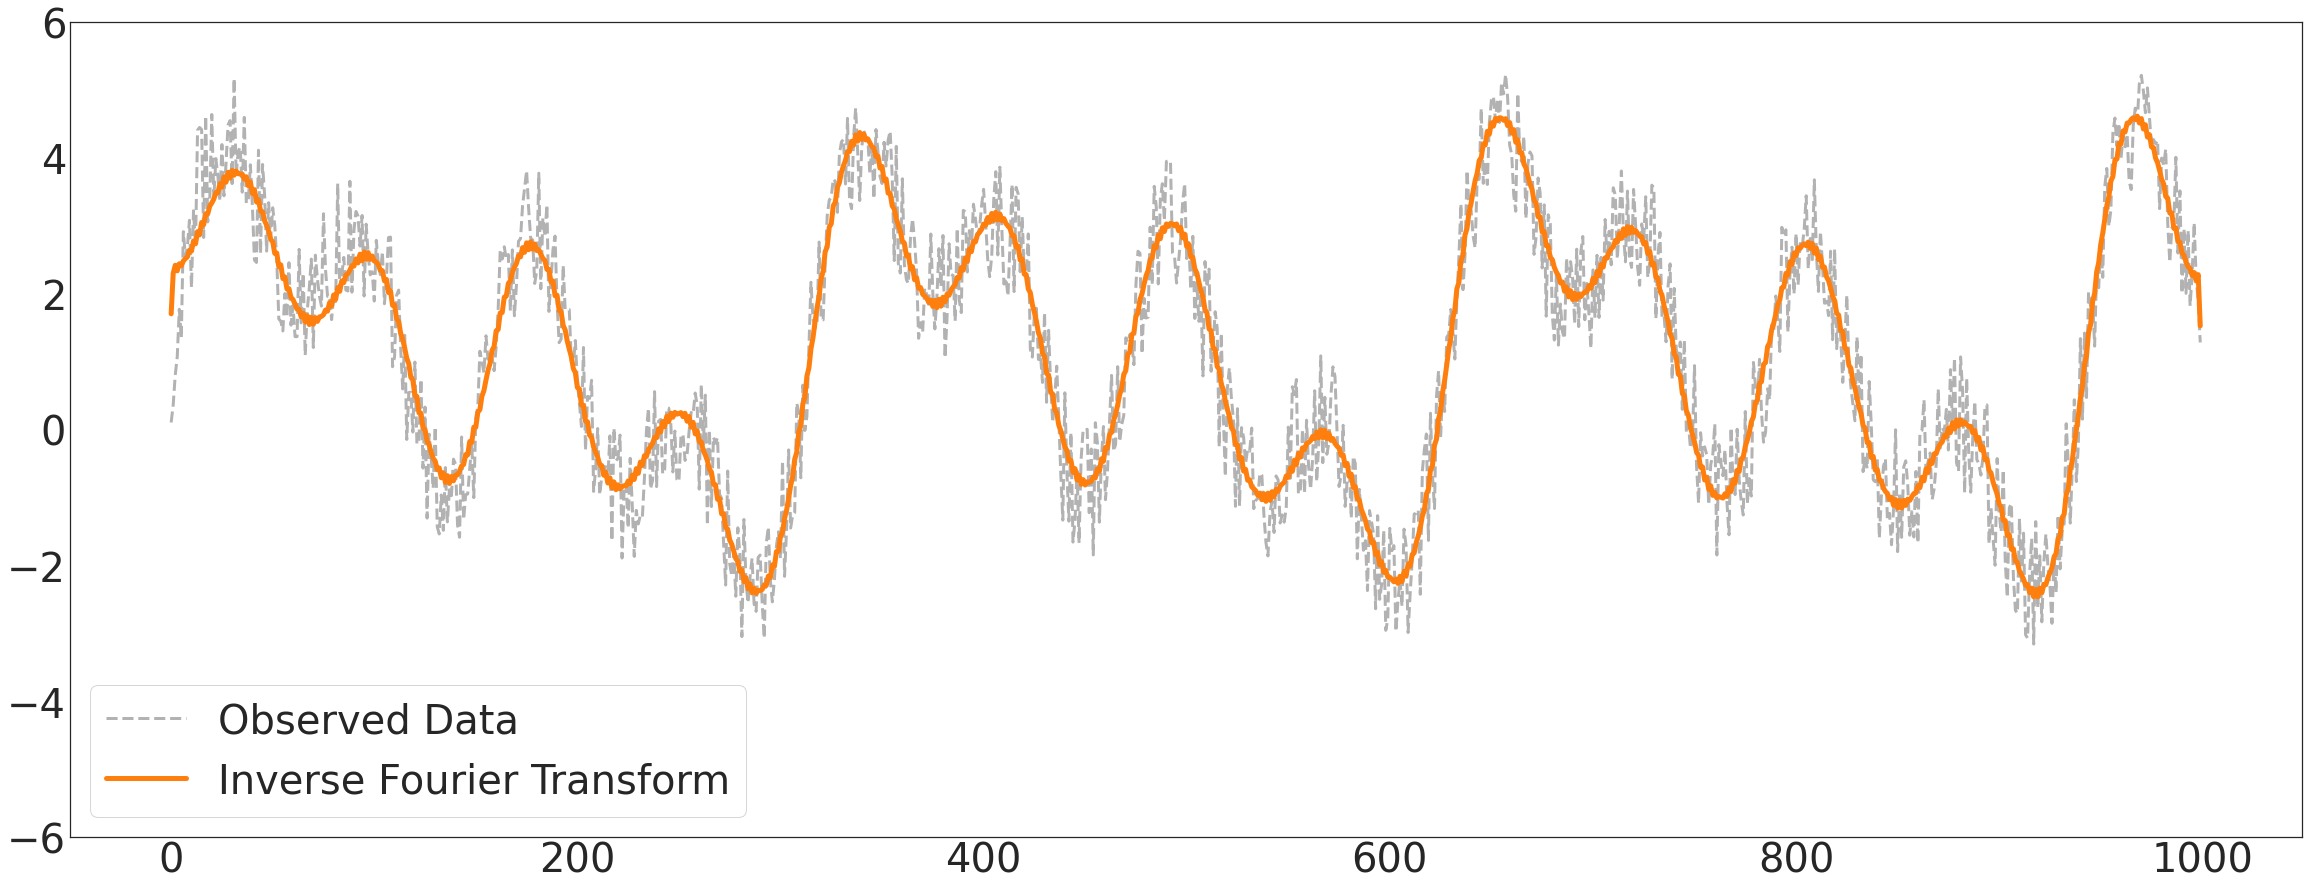

In [403]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    ax1.plot(_x,'k--',label='Observed Data',lw=3,alpha=0.3)
    ax1.plot(itstgcn.make_Psi(_T)@ebayesthresh(FloatVector(itstgcn.make_Psi(_T).T@np.array(_x))),'-',color='C1',label='Inverse Fourier Transform',lw=5)
    ax1.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
    ax1.set_ylim(-6,6)
plt.savefig('Ebayes_fth.pdf', format='pdf')

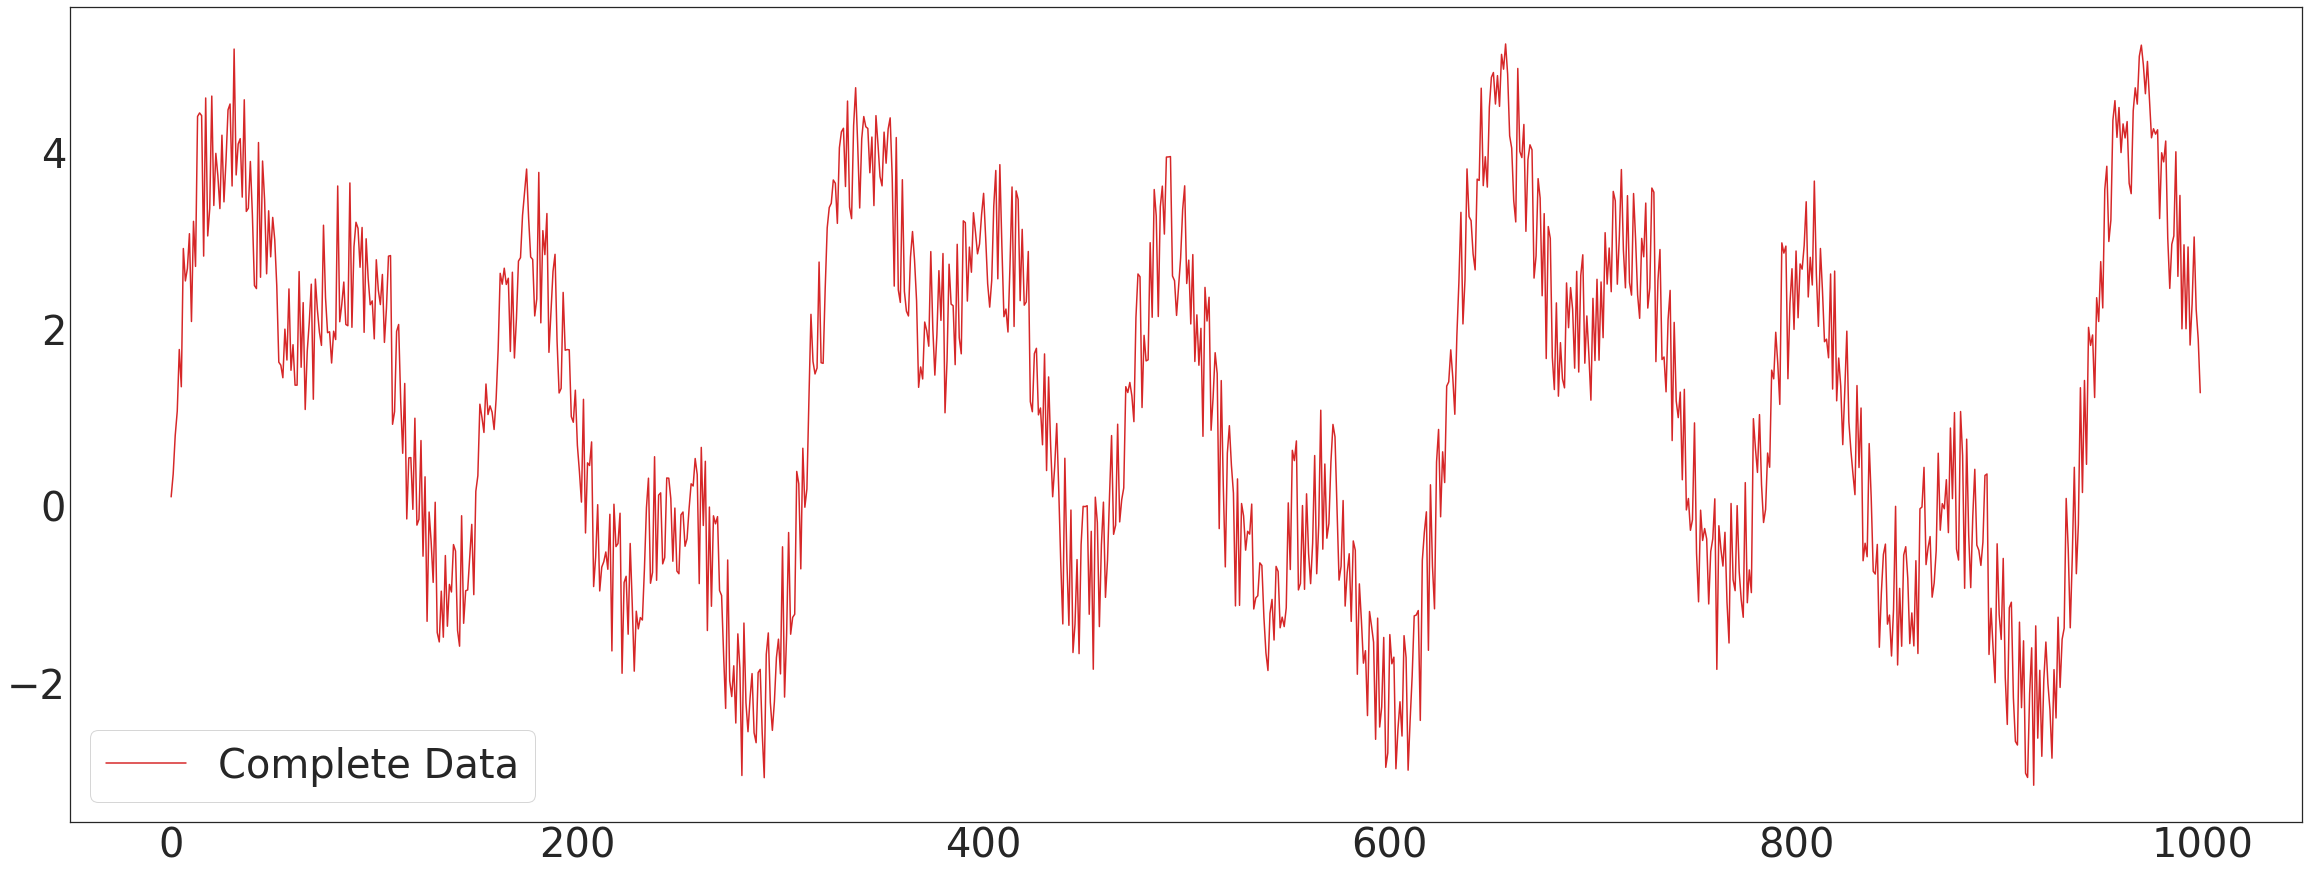

In [450]:
with plt.style.context('seaborn-white'):
    fig, ax1 = plt.subplots(figsize=(40,15))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(data1['x'][:],'-',color='C3',label='Complete Data')
    ax1.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax1.tick_params(axis='y', labelsize=40)
    ax1.tick_params(axis='x', labelsize=40)
# plt.savefig('node1_fst.png')

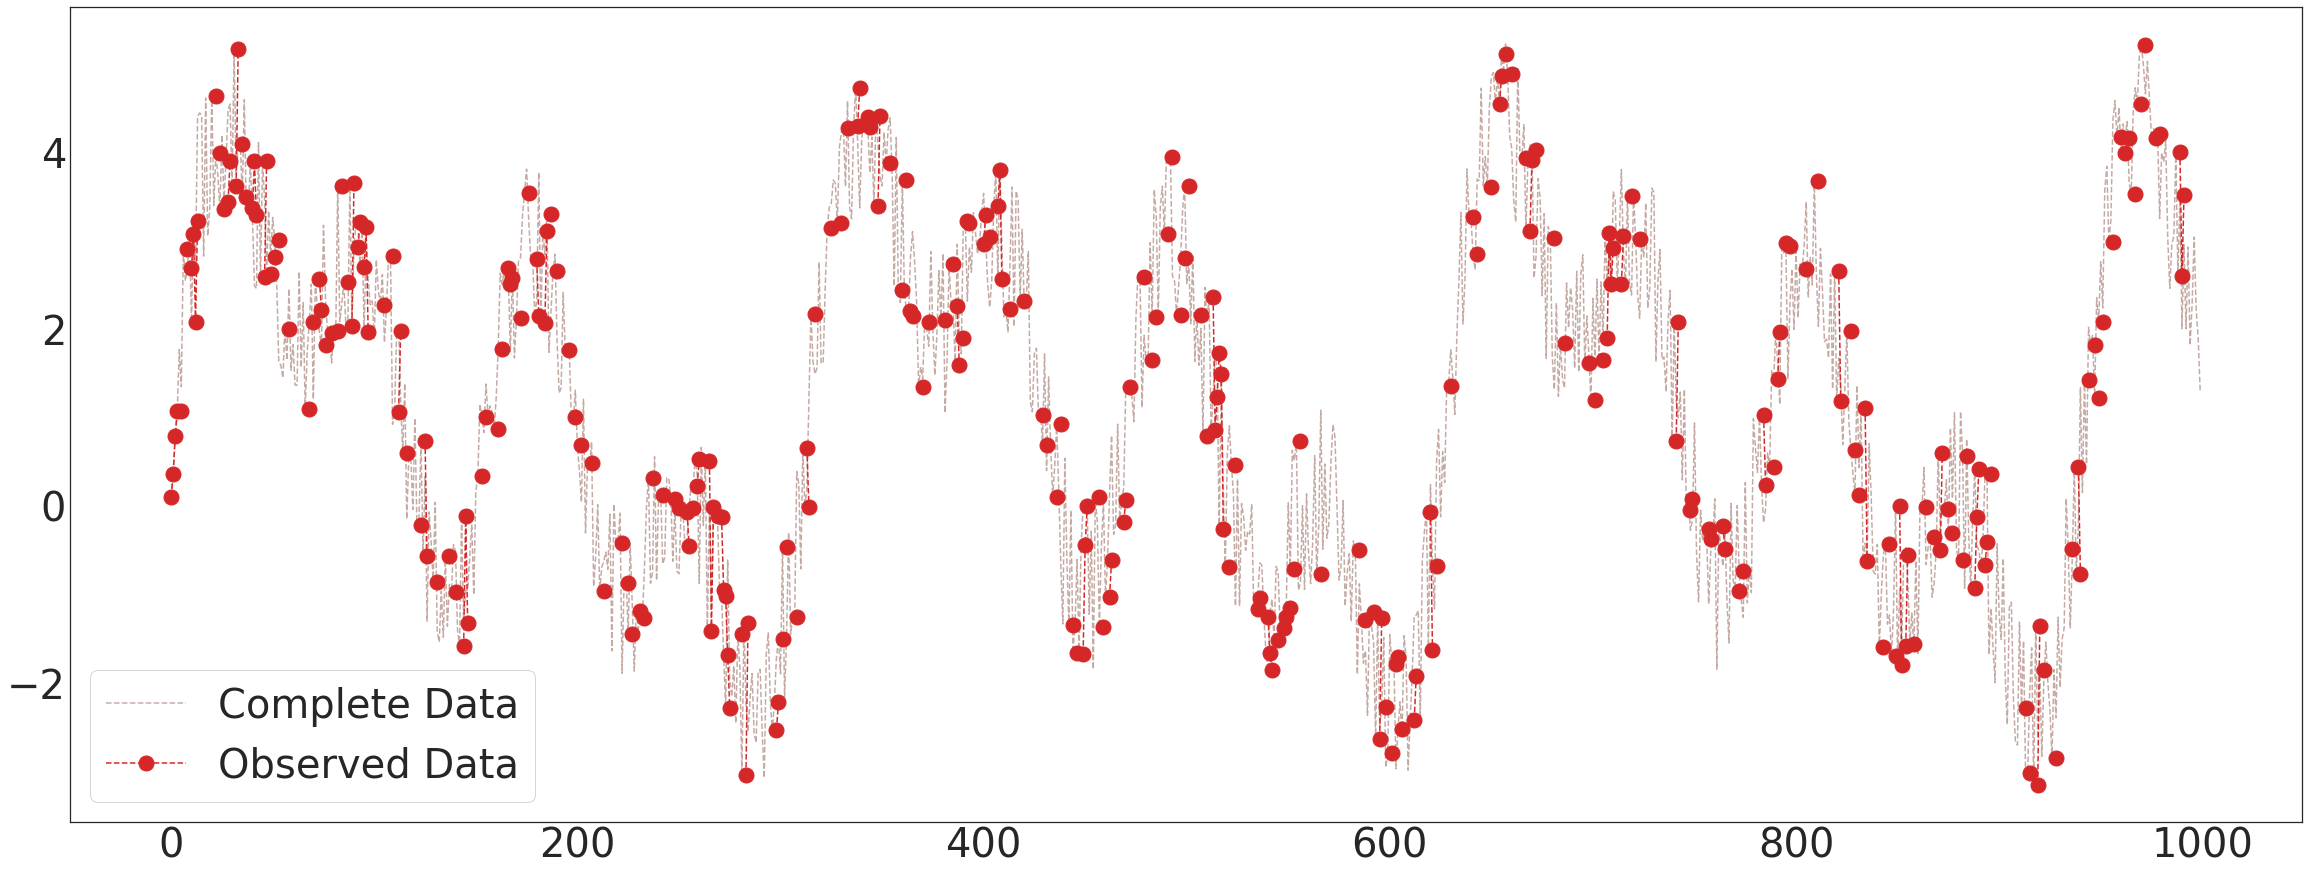

In [451]:
with plt.style.context('seaborn-white'):
    fig, ax2 = plt.subplots(figsize=(40,15))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax2.plot(data1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax2.plot(torch.cat([torch.tensor(data1['x'][:4]),torch.tensor(dataset_miss.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',label='Observed Data',markersize=15)
    ax2.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=40)
    ax2.tick_params(axis='x', labelsize=40)
# plt.savefig('node1_snd.png')

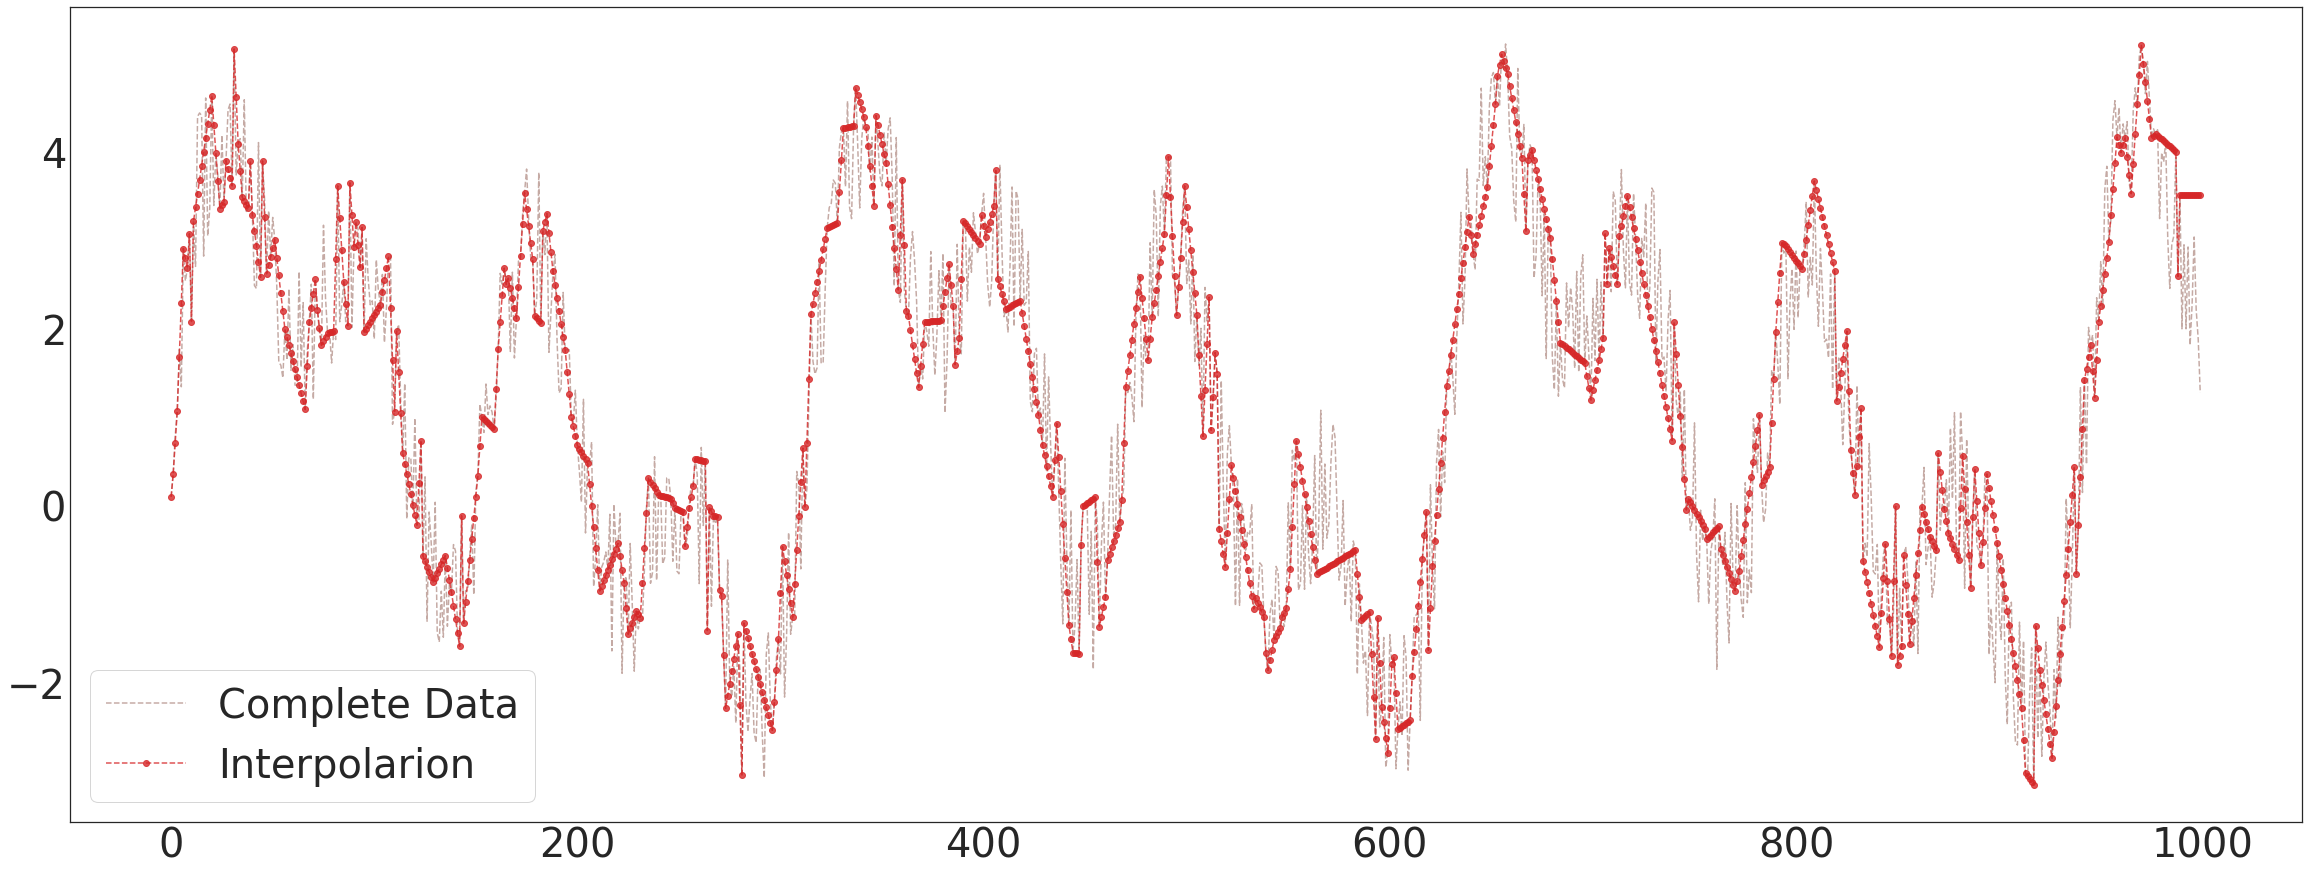

In [452]:
with plt.style.context('seaborn-white'):
    fig, ax3 = plt.subplots(figsize=(40,15))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)    
    ax3.plot(data1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(evtor_2.f_tr[:,0],'--o',color='C3',alpha=0.8,label='Interpolarion')
    ax3.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=40)
    ax3.tick_params(axis='x', labelsize=40)
# plt.savefig('node1_3rd.png')

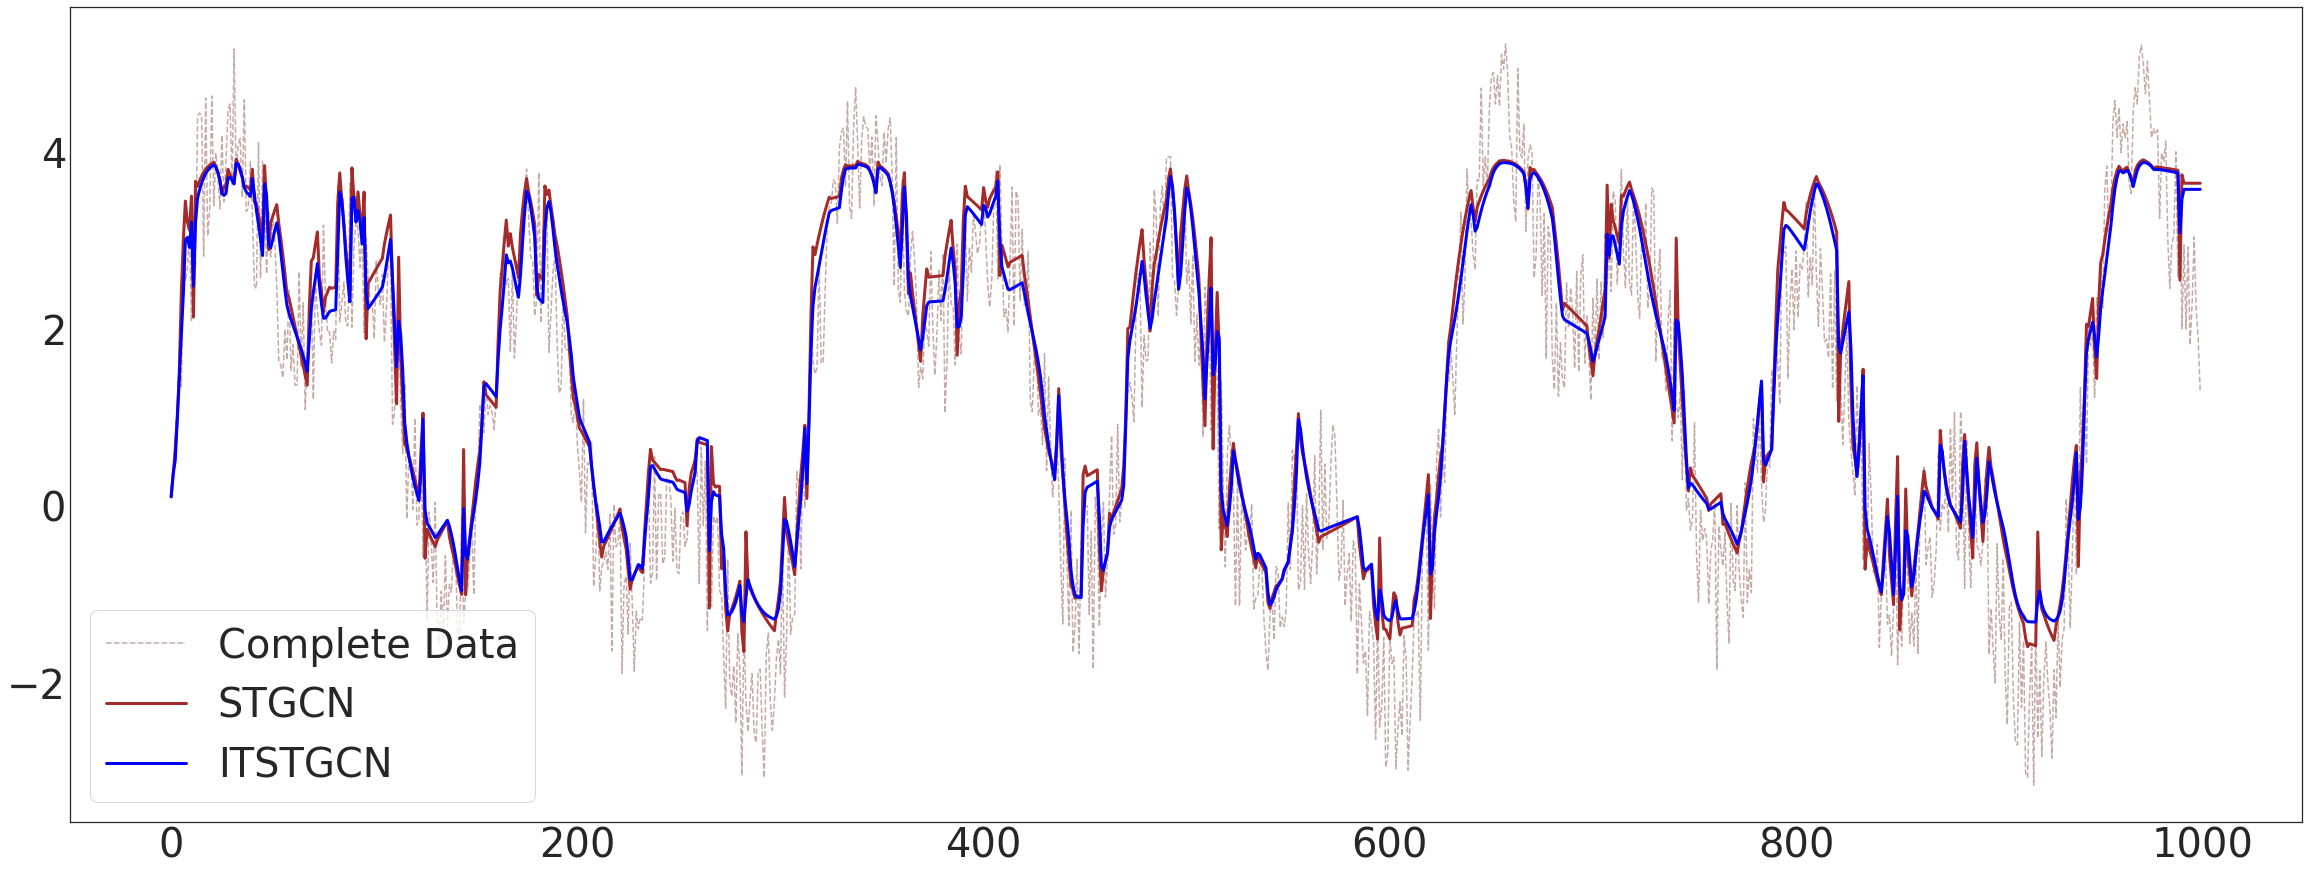

In [453]:
with plt.style.context('seaborn-white'):
    fig, ax4 = plt.subplots(figsize=(40,15))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax4.plot(data1['x'][:],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(evtor.fhat_tr[:,0],color='brown',lw=3,label='STGCN')
    ax4.plot(evtor_2.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN')
    # ax4.plot(138, -1.2, 'o', markersize=230, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(220, -1.5, 'o', markersize=200, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(290, -1.2, 'o', markersize=310, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(455, -0.9, 'o', markersize=280, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax4.legend(fontsize=40,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=40)
    ax4.tick_params(axis='x', labelsize=40)
# plt.savefig('node1_4th_1.png')

Djuric, Petar, and Cédric Richard. 2018. *Cooperative and Graph Signal
Processing: Principles and Applications*. Academic Press.

Johnstone, Iain M, and Bernard W Silverman. 2004. “Needles and Straw in
Haystacks: Empirical Bayes Estimates of Possibly Sparse Sequences.”